# CAM을 만들고 평가해 보자

이미지 분류 모델이 이미지의 어느 영역의 정보에 집중하였는지를 확인할 수 있는 Class Activation Map을 획득하는 실험을 진행합니다. Class Acivation Map은 네트워크를 일부 수정하여 분류 네트워크에서 localization을 어느 정도 수행할 수 있도록 만들어 줍니다.  
네트워크는 ImageNet 데이터를 사용하여 사전학습이 완료된 ResNet-50을 사용하고, 데이터는 120 종의 강아지를 분류하는 데이터셋 [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html)을 사용합니다.

![cam_paper](img/g06_cam_paper.png)

*Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.*

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

## 데이터 준비

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split=["train", "test"],
    shuffle_files=True,
    with_info=True,
)

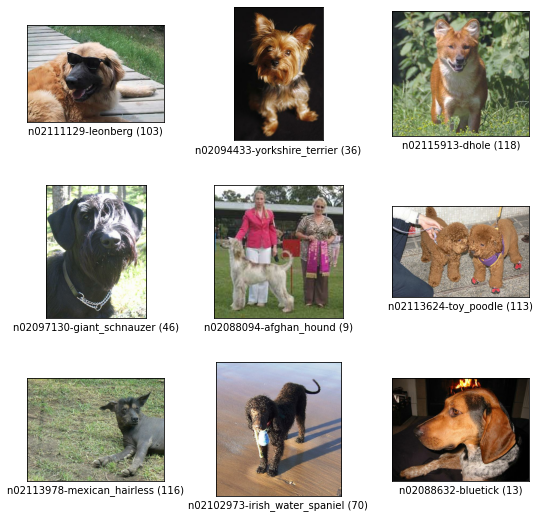

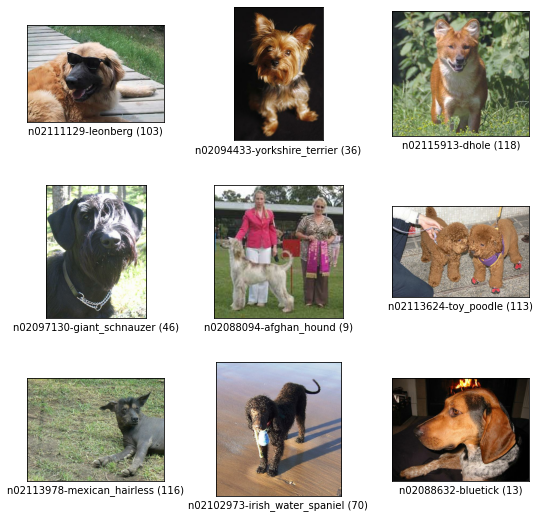

In [3]:
tfds.show_examples(ds_train, ds_info)

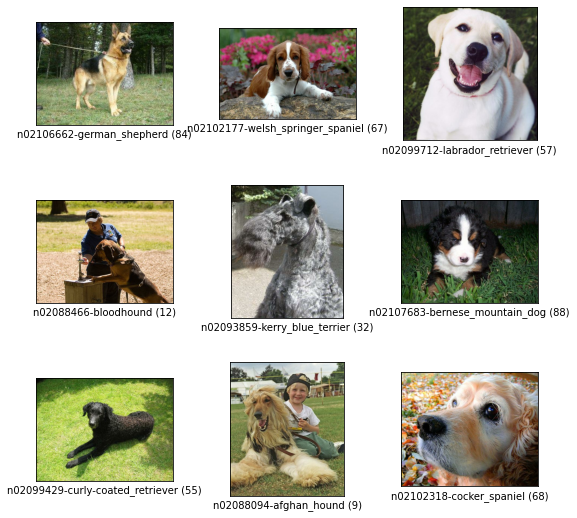

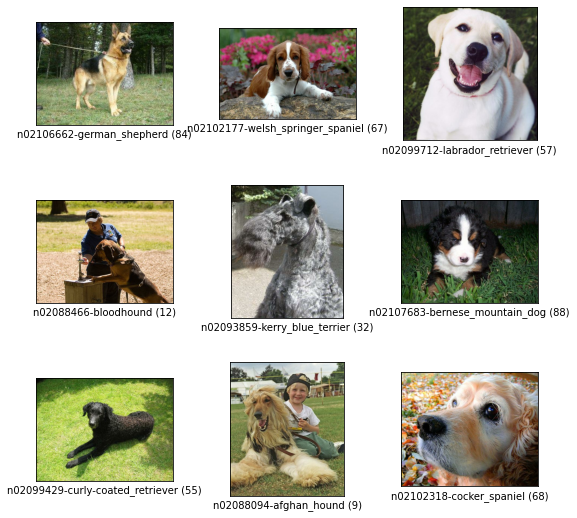

In [4]:
tfds.show_examples(ds_test, ds_info)

## 모델 정의 및 학습

ImageNet의 데이터에 맞추어 사용된 top layer, 즉 fully connected layer를 제외한 모델을 사용합니다. 또한 Global Average Pooling을 사용합니다.

In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg",
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation="softmax")(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [6]:
# cam_model.summary()

데이터셋의 크기를 변경하고 값을 정규화하는 함수를 정의합니다.

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input["image"], [224, 224])
    input["image"] = tf.cast(image, tf.float32) / 255.0
    return input["image"], input["label"]


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

데이터셋에 전처리를 적용하고 배치 크기로 구성합니다.

In [8]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

### 모델 학습

In [9]:
cam_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 168s 210ms/step - loss: 2.2147 - accuracy: 0.4448 - val_loss: 3.5886 - val_accuracy: 0.1743
Epoch 2/5
750/750 [==============================] - 156s 208ms/step - loss: 0.7667 - accuracy: 0.7857 - val_loss: 1.2037 - val_accuracy: 0.6549
Epoch 3/5
750/750 [==============================] - 156s 208ms/step - loss: 0.2574 - accuracy: 0.9444 - val_loss: 0.9421 - val_accuracy: 0.7271
Epoch 4/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0792 - accuracy: 0.9910 - val_loss: 0.9089 - val_accuracy: 0.7348
Epoch 5/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0300 - accuracy: 0.9990 - val_loss: 0.9029 - val_accuracy: 0.7346


In [11]:
# import os

# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)
# print("저장 완료!")

## CAM 구현

CAM 결과를 확인할 샘플 이미지를 하나 선택합니다.

In [12]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]["objects"]["bbox"]
    image = sample_data[0]["image"]
    label = sample_data[0]["label"]
    return sample_data[0]

116


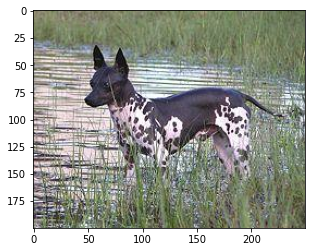

In [13]:
item = get_one(ds_test)
print(item["label"])
plt.imshow(item["image"])
plt.show()

Class Activation Map을 만드는 함수를 정의합니다. 학습이 완료된 모델에서 fully connected layer와 GAP layer를 통과하지 않은, 가장 마지막 convolution layer의 출력과 모델의 가장 마지막 fully connected layer의 가중치를 사용합니다.

In [14]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item["image"].shape[1]
    height = item["image"].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    cam_model = tf.keras.models.Model(
        [model.inputs], [model.layers[-3].output, model.output]
    )
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))

    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)  # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))  # 원래 이미지의 크기로 resize합니다.
    return cam_image

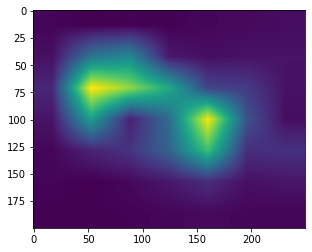

In [15]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

CAM을 입력 이미지와 함께 출력하는 함수를 정의합니다.

In [16]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = 1.0 - alpha
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

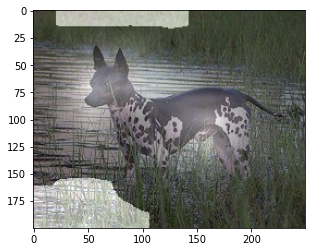

In [17]:
origin_image = item["image"].astype(np.uint8)
cam_image_3channel = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

입력 이미지와 CAM을 함께 확인하면, 강아지가 있는 영역이 주로 활성화가 되었고, 그 중에서도 강아지의 머리 부분이 많이 활성화가 되어 있는 것을 확인할 수 있습니다.

## Grad-CAM 구현

Grad-CAM 결과를 확인할 이미지를 하나 선택합니다.

100


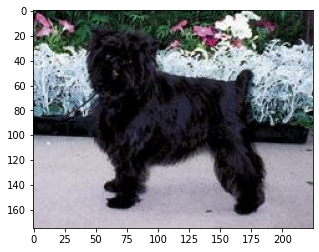

In [18]:
item = get_one(ds_test)
print(item["label"])
plt.imshow(item["image"])
plt.show()

Grad-CAM을 만드는 함수를 구현합니다.
- CAM과 달리 가장 마지막 convolution의 출력뿐만 아니라 다른 convolution의 출력 결과를 사용할 수 있습니다.
- 특정 layer에서의 gradient를 구하고, gradient의 평균을 구합니다.
- gradient의 평균을 weight로 사용하여 activation map을 얻습니다.

In [19]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item["image"].shape[1]
    height = item["image"].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(activation_layer).output, model.output]
    )

    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx]  # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0]  # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0]  # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1))  # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

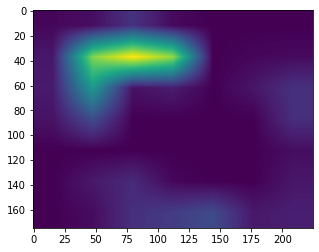

In [20]:
grad_cam_image_5 = generate_grad_cam(cam_model, "conv5_block3_out", item)
plt.imshow(grad_cam_image_5)
plt.show()

강아지의 머리 영역에 집중적으로 활성화가 되어 있음을 확인할 수 있습니다.

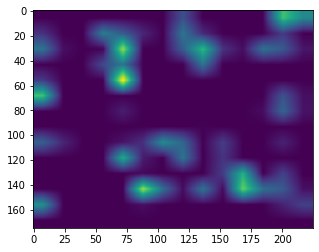

In [21]:
grad_cam_image_4 = generate_grad_cam(cam_model, "conv4_block3_out", item)
plt.imshow(grad_cam_image_4)
plt.show()

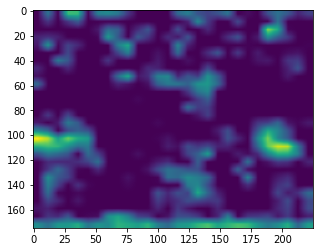

In [22]:
grad_cam_image_3 = generate_grad_cam(cam_model, "conv3_block3_out", item)
plt.imshow(grad_cam_image_3)
plt.show()

`conv3`과 `conv4`의 Grad-CAM 결과는 강아지가 존재하는 영역 이외의 부분들이 활성화 되었습니다.

## BBox

CAM과 Grad-CAM을 사용하여 물체가 존재하는 bounding box를 찾습니다.
- 기준치(0.05)보다 작은 정보는 사용하지 않습니다(0으로 변환합니다).
- openCV의 함수를 사용하여 0 보다 큰 픽셀들이 포함되어 있는 contour를 찾고, 해당 contour를 포함하는 bbox를 찾습니다.

### BBox with CAM

In [23]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)

    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

67


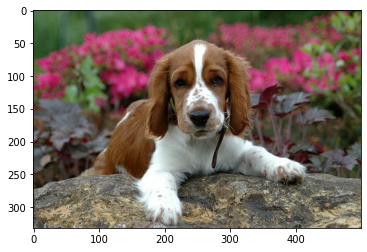

In [24]:
item = get_one(ds_test)
print(item["label"])
plt.imshow(item["image"])
plt.show()

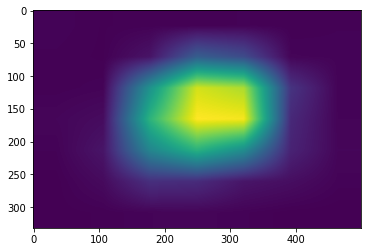

In [25]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [26]:
rect = get_bbox(cam_image)
rect

array([[108,  33],
       [439,  33],
       [439, 289],
       [108, 289]])

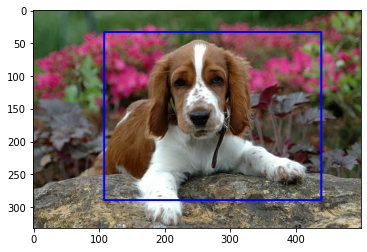

In [27]:
image = copy.deepcopy(item["image"])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

CAM의 결과를 사용하여 객체의 위치 검출이 잘 이루어졌음을 확인할 수 있습니다.

### BBox with Grad-CAM

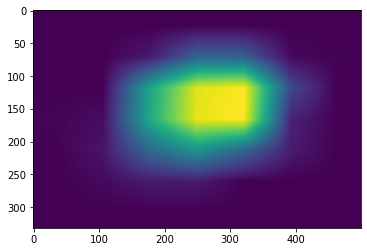

In [28]:
grad_cam_image_5 = generate_grad_cam(cam_model, "conv5_block3_out", item)
plt.imshow(grad_cam_image_5)
plt.show()

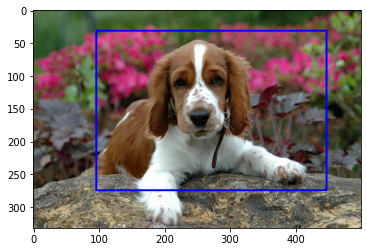

In [29]:
rect_grad = get_bbox(grad_cam_image_5)
image = copy.deepcopy(item["image"])
image = cv2.drawContours(image, [rect_grad], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

Grad-CAM의 결과 역시 객체의 위치를 잘 예측하였습니다.

## IoU
IoU(Intersection of Union)는 정답과 예측의 intersection을 정답과 예측의 union으로 나눈 값으로 객체 탐지 분야에서 성능을 평가하는 지표로 사용됩니다.

![img/g06_iou](img/g06_iou.png)

In [30]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:, 1].min() / float(image.shape[0]),  # bounding box의 y_min
        rect[:, 0].min() / float(image.shape[1]),  # bounding box의 x_min
        rect[:, 1].max() / float(image.shape[0]),  # bounding box의 y_max
        rect[:, 0].max() / float(image.shape[1]),  # bounding box의 x_max
    ]
    return bbox

CAM을 사용하여 얻은 rect를 bbox 형태로 변환합니다.

In [31]:
pred_bbox = rect_to_minmax(rect, item["image"])
pred_bbox

[0.09939759036144578, 0.216, 0.8704819277108434, 0.878]

입력 데이터의 Bounding box를 확인합니다

In [32]:
item["objects"]["bbox"]

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

IoU 계산 함수를 구현합니다.

In [33]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### IoU of CAM

In [34]:
get_iou(pred_bbox, item["objects"]["bbox"][0])

0.6985431810033831

### IoU of Grad-CAM

In [35]:
pred_bbox = rect_to_minmax(rect_grad, item["image"])
get_iou(pred_bbox, item["objects"]["bbox"][0])

0.6664799546891901

## CAM, Grad-CAM 비교


|  | CAM (IoU = 0.699) | Grad-CAM  (IoU = 0.666) |
| --- | --- | --- |
| Activation Map | ![g06_cam_exam](img/g06_cam_exam.png) | ![g06_grad_exam](img/g06_grad_exam.png) |
| BBox | ![g06_cam_bbox](img/g06_cam_bbox.png) | ![g06_grad_bbox](img/g06_grad_bbox.png) |


## 루브릭

| 평가문항                                            | 상세기준                                                                                               |
| ----------------------------------------------- | -------------------------------------------------------------------------------------------------- |
| 1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?          | ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.                                         |
| 2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? | CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.       |
| 3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?               | CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다. |

### 루브릭 자체평가

1. CAM을 위한 ResNet-50 모델의 학습이 정상적으로 이루어졌다.
2. CAM과 Grad-CAM의 결과를 얻을 수 있었으며, 객체의 주요한 특징이 존재하는 영역을 표시하였다.
3. CAM과 Grad-CAM에 대한 영역 출력과 bbox 검출, 그리고 IoU 계산 과정이 이루어졌다.